# 나랑 닮은 연예인은 누구?

## 1. 데이터 준비

### 1.1 크롤링할 인물 이름 로드

In [1]:
import numpy as np
import tensorflow as tf
import re

actor_list_path = "./actor.csv"
singer_list_path = "./singer.csv"
entertainer_list_path = "./entertainer.csv"

celeb_list = []
with open(actor_list_path, encoding='utf-8-sig') as f:
  for actor in f.readlines():
    celeb_list.append(re.sub('[()-]', ' ', actor).strip())

with open(singer_list_path, encoding='utf-8-sig') as f:
  for singer in f.readlines():
    celeb_list.append(re.sub('[()-]', ' ', singer).strip())
    
with open(entertainer_list_path, encoding='utf-8-sig') as f:
  for entertainer in f.readlines():
    celeb_list.append(re.sub('[()-]', ' ', entertainer).strip())
    
len(celeb_list)

3027

### 1.2 이미지 크롤링
네이버 인물 검색 결과에서 썸네일을 크롤링합니다.

In [4]:
from urllib.parse import quote_plus
from bs4 import BeautifulSoup
import requests
import os
import time
import urllib.request

class ImageScraper:
    
    def __init__(self):
        self.alredy_scrap = []
        self.not_found_image = []
        self.members = []
    
    def scrap(self, name, save_path="./data", interval=0):
        if (os.path.isfile("./data/"+name+".jpg")):
            self.alredy_scrap.append(name)
            return

        if (interval>0):
            time.sleep(interval)
        
        baseUrl = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query='
        url = baseUrl + quote_plus(name)
        raw = requests.get(url)
        soup = BeautifulSoup(raw.text, 'html.parser')

        try:
            profile_wrap = soup.find("div",class_="profile_wrap")
            
            # 멤버가 여러명인 그룹이라면 각 멤버 검색
            first_label = profile_wrap.select_one("dt:nth-of-type(1)").get_text()
            if(first_label=="멤버"):
                members = list(map(lambda x: x.get_text(),profile_wrap.select("dd:nth-of-type(2) > a")))
                for member in members:
                    self.scrap(member, save_path, interval)
                return
            
            big_thumb = profile_wrap.find("div",class_="big_thumb")
            img = big_thumb.find("img")
            image_url = img["src"]
            
        except AttributeError as error:
            self.not_found_image.append(name)
            return None

        if not os.path.isdir(save_path):
            os.makedirs(save_path)

        local_image_path = os.path.join(save_path, name+".jpg")
        urllib.request.urlretrieve(image_url, local_image_path)
        
        return local_image_path

In [8]:
image_scraper = ImageScraper()
image_scraper.scrap("장도연")

'./data/장도연.jpg'

In [9]:
from tqdm import tqdm

pbar = tqdm(celeb_list)
for actor in pbar:
    pbar.set_description(actor)
    image_scraper.scrap(actor, interval=0)

print("중복된 이미지 {} 건".format(len(image_scraper.alredy_scrap)))
print("찾을 수 없는 이미지 {} 건".format(len(image_scraper.not_found_image)))

dir_path = './data/'
file_list = os.listdir(dir_path)
print("다운로드 받은 이미지 {} 건".format(len(file_list)))

김익근: 100%|██████████| 3027/3027 [19:00<00:00,  2.65it/s] ]      ]                 

중복된 이미지 2263 건
찾을 수 없는 이미지 474 건
다운로드 받은 이미지 2445 건


### 1.3 크롤링한 이미지 확인

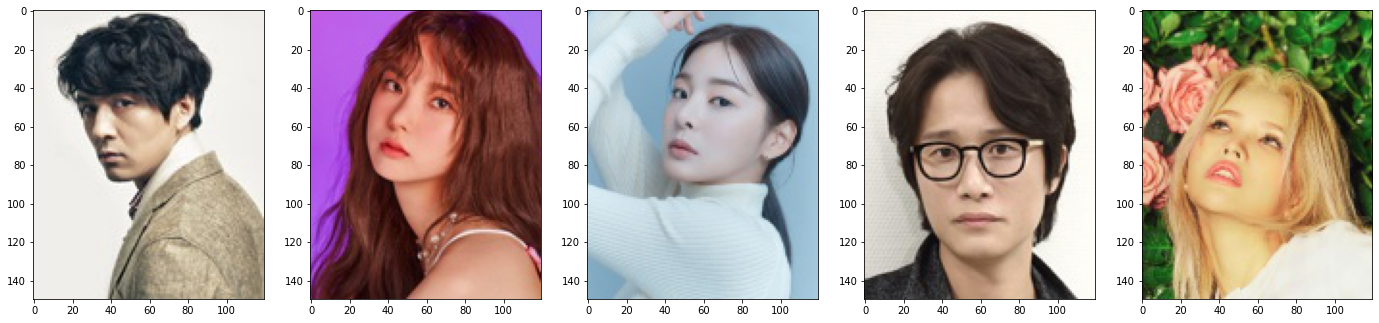

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as img

#Set figsize here
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path+file_list[i])
    ax.imshow(image)
    
plt.show()

fig.tight_layout()

## 2. 이미지 전처리

### 2.1 얼굴 영역 검출

In [11]:
import face_recognition
import os

def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

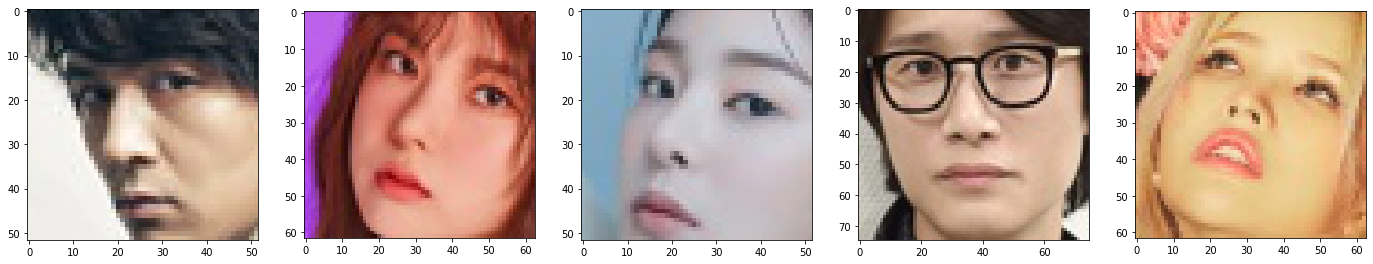

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,10))

for i, ax in enumerate(axes.flatten()):
    image = get_cropped_face(dir_path+file_list[i])
    ax.imshow(image)
    
plt.show()

fig.tight_layout()

### 2.2 얼굴 영역 embadding

In [13]:
image_file = os.path.join(dir_path, '송새벽.jpg')
face = get_cropped_face(image_file)   # 얼굴 영역을 구하는 함수(이전 스텝에서 구현)

# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)  
embedding

[array([-0.07739156,  0.13227783,  0.07058435, -0.02396249, -0.08083812,
         0.03782659, -0.15806065, -0.08686386,  0.14144506, -0.14178857,
         0.19599427,  0.01701015, -0.14156412, -0.10583911,  0.00698975,
         0.20337529, -0.16878945, -0.13720134, -0.00408113, -0.02877567,
         0.02339112,  0.00767127,  0.05071754,  0.01076538, -0.06954931,
        -0.35700348, -0.11283565, -0.03903834,  0.05048529, -0.05054228,
        -0.06871242,  0.04960131, -0.10610315,  0.00443777,  0.06832725,
         0.16665049, -0.02383609, -0.06697384,  0.17290917, -0.06834951,
        -0.23004037,  0.04713515,  0.05554311,  0.22288065,  0.19516914,
        -0.00618839,  0.05201473, -0.1259875 ,  0.14451303, -0.10927393,
         0.08262592,  0.17726889,  0.06711207,  0.08016171,  0.04572301,
        -0.11135536,  0.03620227,  0.14940558, -0.05871207, -0.01246508,
         0.06924523, -0.06054142, -0.01083236, -0.02981983,  0.17756069,
         0.09415259, -0.10254125, -0.30283222,  0.1

### 2.3 얼굴 영역을 embadding 해서 dictionary에 저장

In [14]:
from tqdm import tqdm

def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    error_files = []
    
    for file in tqdm(file_list):
        try:
            img_path = os.path.join(dir_path, file)
            name = file.split(".")[0]
            face = get_cropped_face(img_path)
            embedding = get_face_embedding(face)
            if len(embedding) > 0:  
                embedding_dict[name] = embedding[0]
        except:
            error_files.append(file)
        
    return embedding_dict, error_files

embedding_dict, error_files = get_face_embedding_dict(dir_path)
print("{}개의 파일에서 얼굴을 찾지 못했습니다.".format(len(error_files)))
      
embedding_dict['송새벽']

100%|██████████| 2445/2445 [08:32<00:00,  4.77it/s]

119개의 파일에서 얼굴을 찾지 못했습니다.


array([-0.07739156,  0.13227783,  0.07058435, -0.02396249, -0.08083812,
        0.03782659, -0.15806065, -0.08686386,  0.14144506, -0.14178857,
        0.19599427,  0.01701015, -0.14156412, -0.10583911,  0.00698975,
        0.20337529, -0.16878945, -0.13720134, -0.00408113, -0.02877567,
        0.02339112,  0.00767127,  0.05071754,  0.01076538, -0.06954931,
       -0.35700348, -0.11283565, -0.03903834,  0.05048529, -0.05054228,
       -0.06871242,  0.04960131, -0.10610315,  0.00443777,  0.06832725,
        0.16665049, -0.02383609, -0.06697384,  0.17290917, -0.06834951,
       -0.23004037,  0.04713515,  0.05554311,  0.22288065,  0.19516914,
       -0.00618839,  0.05201473, -0.1259875 ,  0.14451303, -0.10927393,
        0.08262592,  0.17726889,  0.06711207,  0.08016171,  0.04572301,
       -0.11135536,  0.03620227,  0.14940558, -0.05871207, -0.01246508,
        0.06924523, -0.06054142, -0.01083236, -0.02981983,  0.17756069,
        0.09415259, -0.10254125, -0.30283222,  0.10245665, -0.08

### 2.4 얼굴을 찾지 못한 사진들

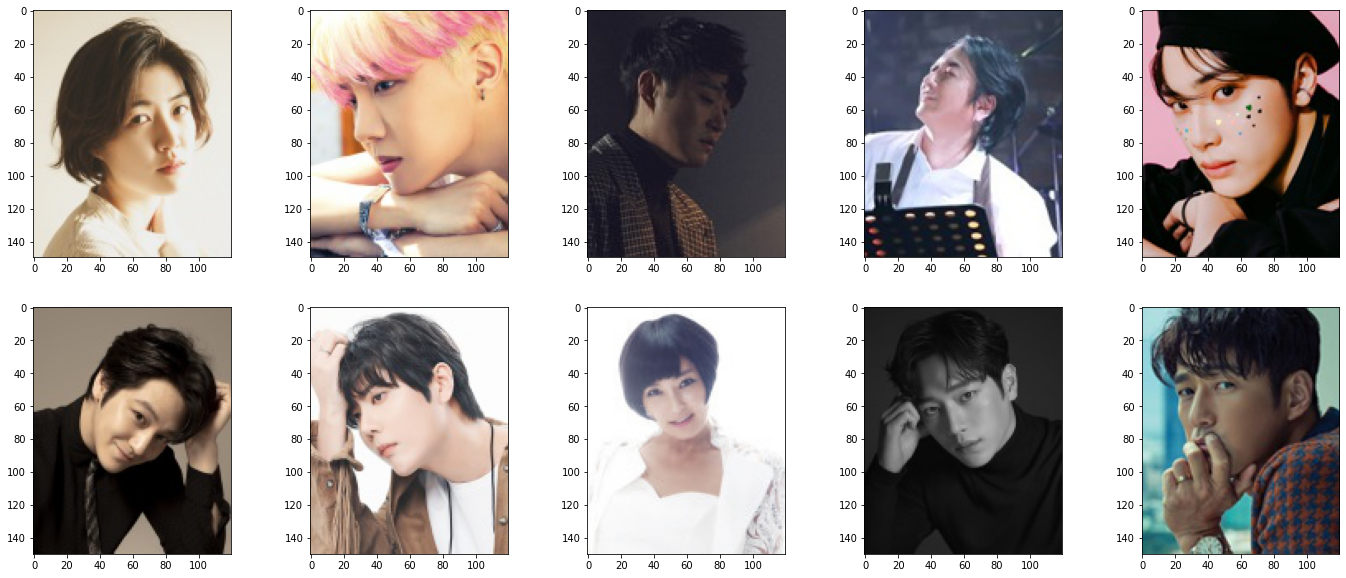

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24,10))

for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path+error_files[i])
    ax.imshow(image)
    
plt.show()

fig.tight_layout()

얼굴을 검출하지 못한 사진들은
1. 사진이 너무 밝거나 어둡다
2. 얼굴의 방향이 정면이 아니다 (큰 각도로 회전되어있다)
3. 얼굴이 머리나 손 등으로 가려져있다
4. 화질이 좋지 않다

## 3. 사진간의 거리 측정

In [16]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

In [17]:
get_distance('정우성', '원빈')

0.6463024453431389

정우성과 원빈은 둘 다 잘생겼지만 거리가 멀다

In [18]:
def get_nearest_face(name, top=5): 
    res = list(map(lambda x: (x[0], get_distance(name,x[0])), embedding_dict.items()))
    res = sorted(res, key=(lambda x: x[1]))
    return res[1:top+1]

nearest_wonbin = get_nearest_face('원빈')

for idx, face in enumerate(nearest_wonbin):
    print("{} - {} : {}".format(idx, face[0], face[1]))

0 - 지윤호 : 0.433505280007157
1 - 김현빈 : 0.47117970474890875
2 - 송재림 : 0.48878494310129506
3 - 박남정 : 0.4891016727429899
4 - 심신 : 0.490942951900461


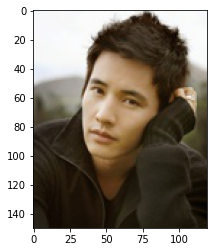

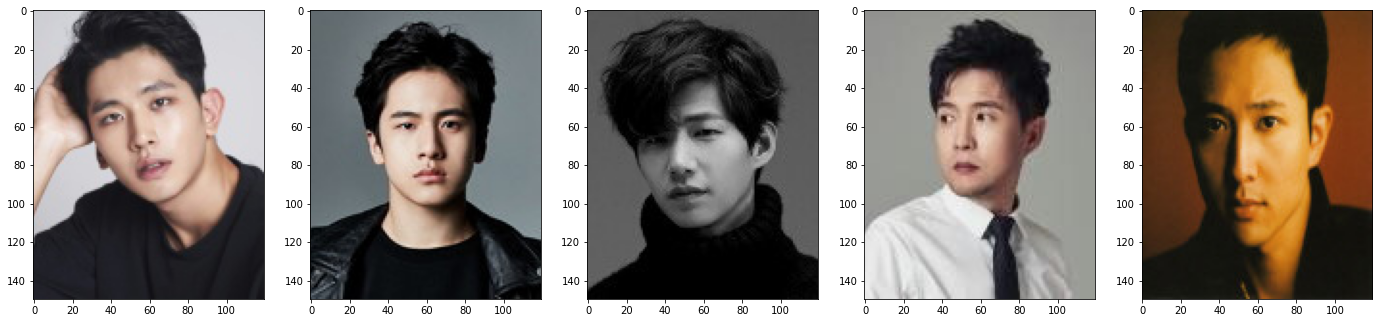

In [19]:
image = img.imread(dir_path+"원빈.jpg")
plt.imshow(image)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,10))

for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path+nearest_wonbin[i][0]+".jpg")
    ax.imshow(image)
    
plt.show()

fig.tight_layout()

## 4. 내 얼굴과 비슷한 연예인을 찾아라!

### 4.1 내 사진 전처리

In [20]:
image_file = os.path.join(dir_path, '김준일.jpg')
face = get_cropped_face(image_file)
embedding_dict["김준일"] = get_face_embedding(face)[0]

image_file = os.path.join(dir_path, '김준일2.jpg')
face = get_cropped_face(image_file)
embedding_dict["김준일2"] = get_face_embedding(face)[0]

embedding_dict["김준일"]

array([-1.82815641e-02,  5.92730492e-02,  3.62543948e-02, -1.25993183e-02,
       -1.21079691e-01, -5.40623367e-02, -6.88296184e-02, -1.40341073e-01,
        5.02859391e-02, -8.62168074e-02,  2.30134785e-01, -4.61791381e-02,
       -2.07255781e-01, -7.87010640e-02,  3.24724764e-02,  1.41017586e-01,
       -1.08252935e-01, -6.79605007e-02, -1.79311082e-01, -1.13887768e-02,
        4.54624090e-03, -4.43588290e-03,  9.16257650e-02,  2.15691719e-02,
       -1.06242880e-01, -3.18148613e-01, -8.99015516e-02,  7.94612244e-03,
        5.67727052e-02, -3.05139814e-02, -8.74541476e-02,  6.56680167e-02,
       -1.99435577e-01, -6.61755428e-02,  4.00427915e-02,  8.59240592e-02,
       -1.10934791e-03, -6.72622398e-02,  1.76512420e-01, -3.32976691e-04,
       -2.22756863e-01,  4.36220616e-02, -2.34108604e-02,  2.24723324e-01,
        2.66631275e-01,  3.56622227e-02,  3.91345173e-02, -7.94246495e-02,
        1.29524440e-01, -2.11270064e-01,  6.06889129e-02,  1.17027245e-01,
        6.69251084e-02,  

### 4.2 내 사진간의 거리 측정

In [25]:
get_distance('김준일','김준일2')

0.35126330889733987

내 사진과 또다른 내 사진과의 거리는 가까운 편이다.

### 4.3 나와 비슷한 연예인 5명!

In [22]:
nearest_junil = get_nearest_face('김준일')

for idx, face in enumerate(nearest_junil):
    print("{} - {} : {}".format(idx, face[0], face[1]))

0 - 김준일2 : 0.35126330889733987
1 - 임병수 : 0.4216600172184895
2 - 최성원 : 0.42848045446923727
3 - 임백천 : 0.44811199997781564
4 - 김정호 : 0.453146381505837


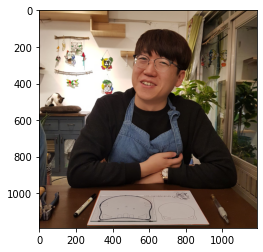

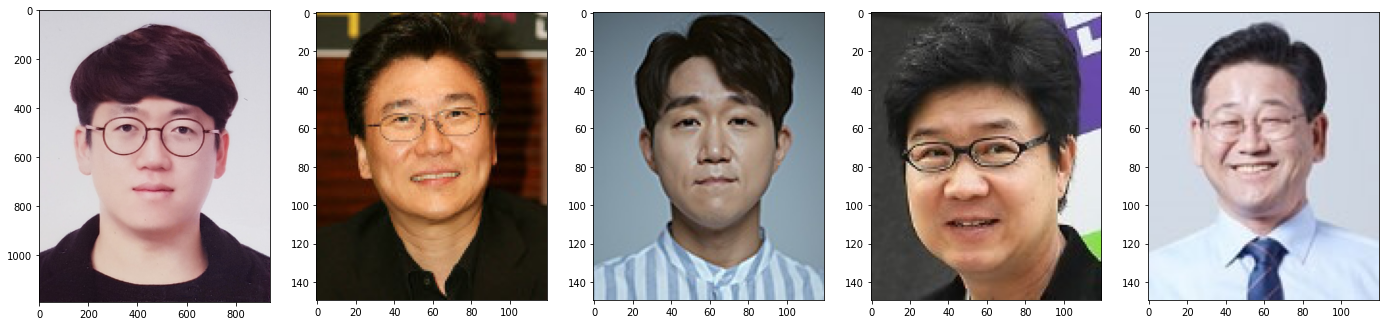

In [23]:
image = img.imread(dir_path+'김준일.jpg')
plt.imshow(image)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,10))

for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path + nearest_junil[i][0]+".jpg")
    ax.imshow(image)
    
plt.show()

fig.tight_layout()

0 - 김준일 : 0.35126330889733987
1 - 노이한 : 0.37115082168838603
2 - 최성원 : 0.39157814300998595
3 - 장수원 : 0.39226977455291
4 - 이준석 : 0.39352969056659304


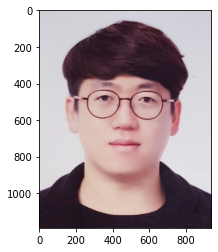

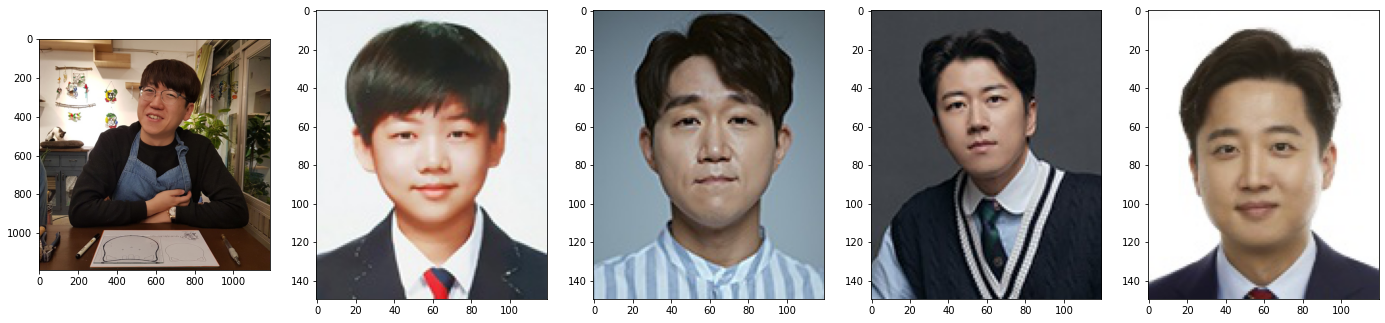

In [26]:
nearest_junil2 = get_nearest_face('김준일2')

for idx, face in enumerate(nearest_junil2):
    print("{} - {} : {}".format(idx, face[0], face[1]))

image = img.imread(dir_path+'김준일2.jpg')
plt.imshow(image)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,10))

for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path + nearest_junil2[i][0]+".jpg")
    ax.imshow(image)
    
plt.show()

fig.tight_layout()

인정하고싶진 않지만 비슷한 것도 같다

### 4.5 나와 가장 비슷하지 않은 연예인은?

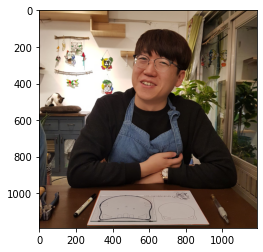

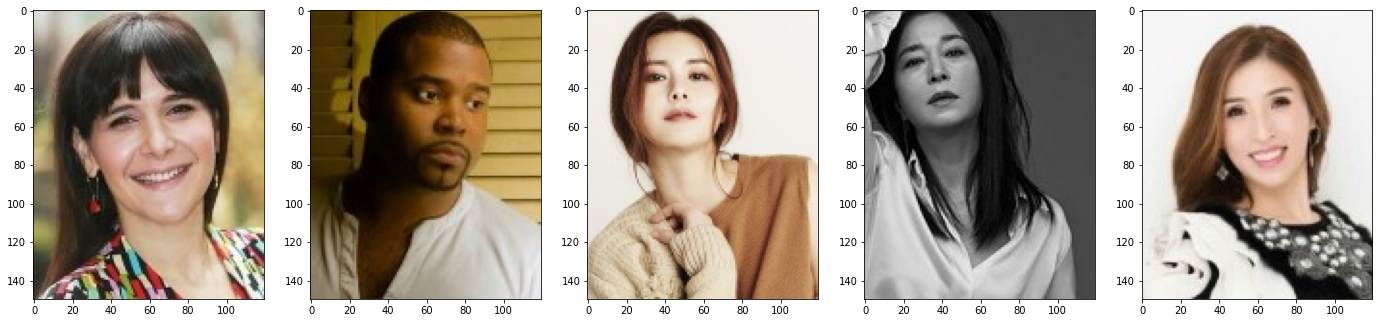

In [32]:
res = list(map(lambda x: (x[0], get_distance("김준일",x[0])), embedding_dict.items()))
res = sorted(res, key=(lambda x: x[1]), reverse=True)
res = res[1:5+1]

image = img.imread(dir_path+'김준일.jpg')
plt.imshow(image)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,10))

for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path + res[i][0]+".jpg")
    ax.imshow(image)
    
plt.show()

fig.tight_layout()